In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from classy import Class
plt.style.use('seaborn')
%matplotlib notebook

## Helper functions

In [2]:
def secondsToHubbletime(seconds):
    """
    Helper function to convert seconds to fractions of Hubble time.
    Returns fraction of Hubble time at (input) seconds
    """
    H0 = 70 * u.km/(u.s * u.Mpc)
    return seconds / (1/H0).to('s').value

# RK4 and growth equation

$$\ddot{\delta} + 2H\dot{\delta}-(3/2) H^2 \Omega_m \delta =0$$
$$\rightarrow \dot{\delta} = u$$
$$\rightarrow \dot{u} = (3/2) H^2 \Omega_m \delta - 2Hu$$

In [3]:
omega0R = 8.4e-5
omega0M = 0.3
omega0L = 1. - omega0R - omega0M

def dadt(t, p):
    return np.sqrt(omega0R * np.power(p[2],-2) + omega0M * np.power(p[2],-1) + omega0L * np.power(p[2],2))

def dddt(t, p):
    return p[1]

def dudt(t, p):
    H = dadt(t,p)/p[2]
    return 3/2 * omega0M/p[2]**3 * p[0] - 2*H*p[1]

In [9]:
def RK4(dydts,tstart,tstop,nt,p0,tspace='log'):
    """
    Function for solving set of diff. eqs of the form dy/dt  = f(t, y) with the Runge Kutta 4 algorithm.
    Non-adaptive stepsize!
    """
    nsystems = len(dydts) #Number of dydts aka size of equation system

    # --- Setup arrays ---
    if tspace == 'log':
        ts = np.logspace(np.log10(tstart),np.log10(tstop),nt)
    elif tspace == 'lin':
        ts = np.linspace(tstart,tstop,nt)
        
    # --- Construct dts and allocate memory for yvals ---
    dts   = np.diff(ts)
    yvals = np.zeros((nt,nsystems),dtype=float)

    # --- Unify diff. eqs to one ---
    def dydt(t,p):
        return np.array([_dydt(t,p) for _dydt in dydts])

    # --- Integrate ---
    yvals[0] = p0
    for (i,dt) in enumerate(dts):
        k1 = dt * dydt(ts[i],yvals[i])
        k2 = dt * dydt(ts[i] + dt/2, yvals[i] + k1/2)
        k3 = dt * dydt(ts[i] + dt/2, yvals[i] + k2/2)
        k4 = dt * dydt(ts[i] + dt, yvals[i] + k3)
        yvals[i+1] = yvals[i] + k1/6 + k2/3 + k3/3 + k4/6
    return ts, yvals

# Evaluer

In [10]:
astart   = 1e-7
tstart   = 1/(np.sqrt(omega0R)) * 1/2 * astart**2

ts, vals = RK4([dddt,dudt,dadt],tstart=tstart,tstop=2,nt=10000,p0=[0.01,0,astart])

In [18]:
# --- Generate values for comparison ---
analyticalAs = (np.sinh(3*ts/2 * np.sqrt(omega0L))**2 * omega0M/omega0L)**(1/3)

cosmo = Class()
Omega_b = 0.05
cosmo.set({'Omega_b':Omega_b, 'Omega_cdm':omega0M - Omega_b, 'H0':70})
cosmo.compute()
bg = cosmo.get_background()
d = bg['gr.fac. D']

<IPython.core.display.Javascript object>


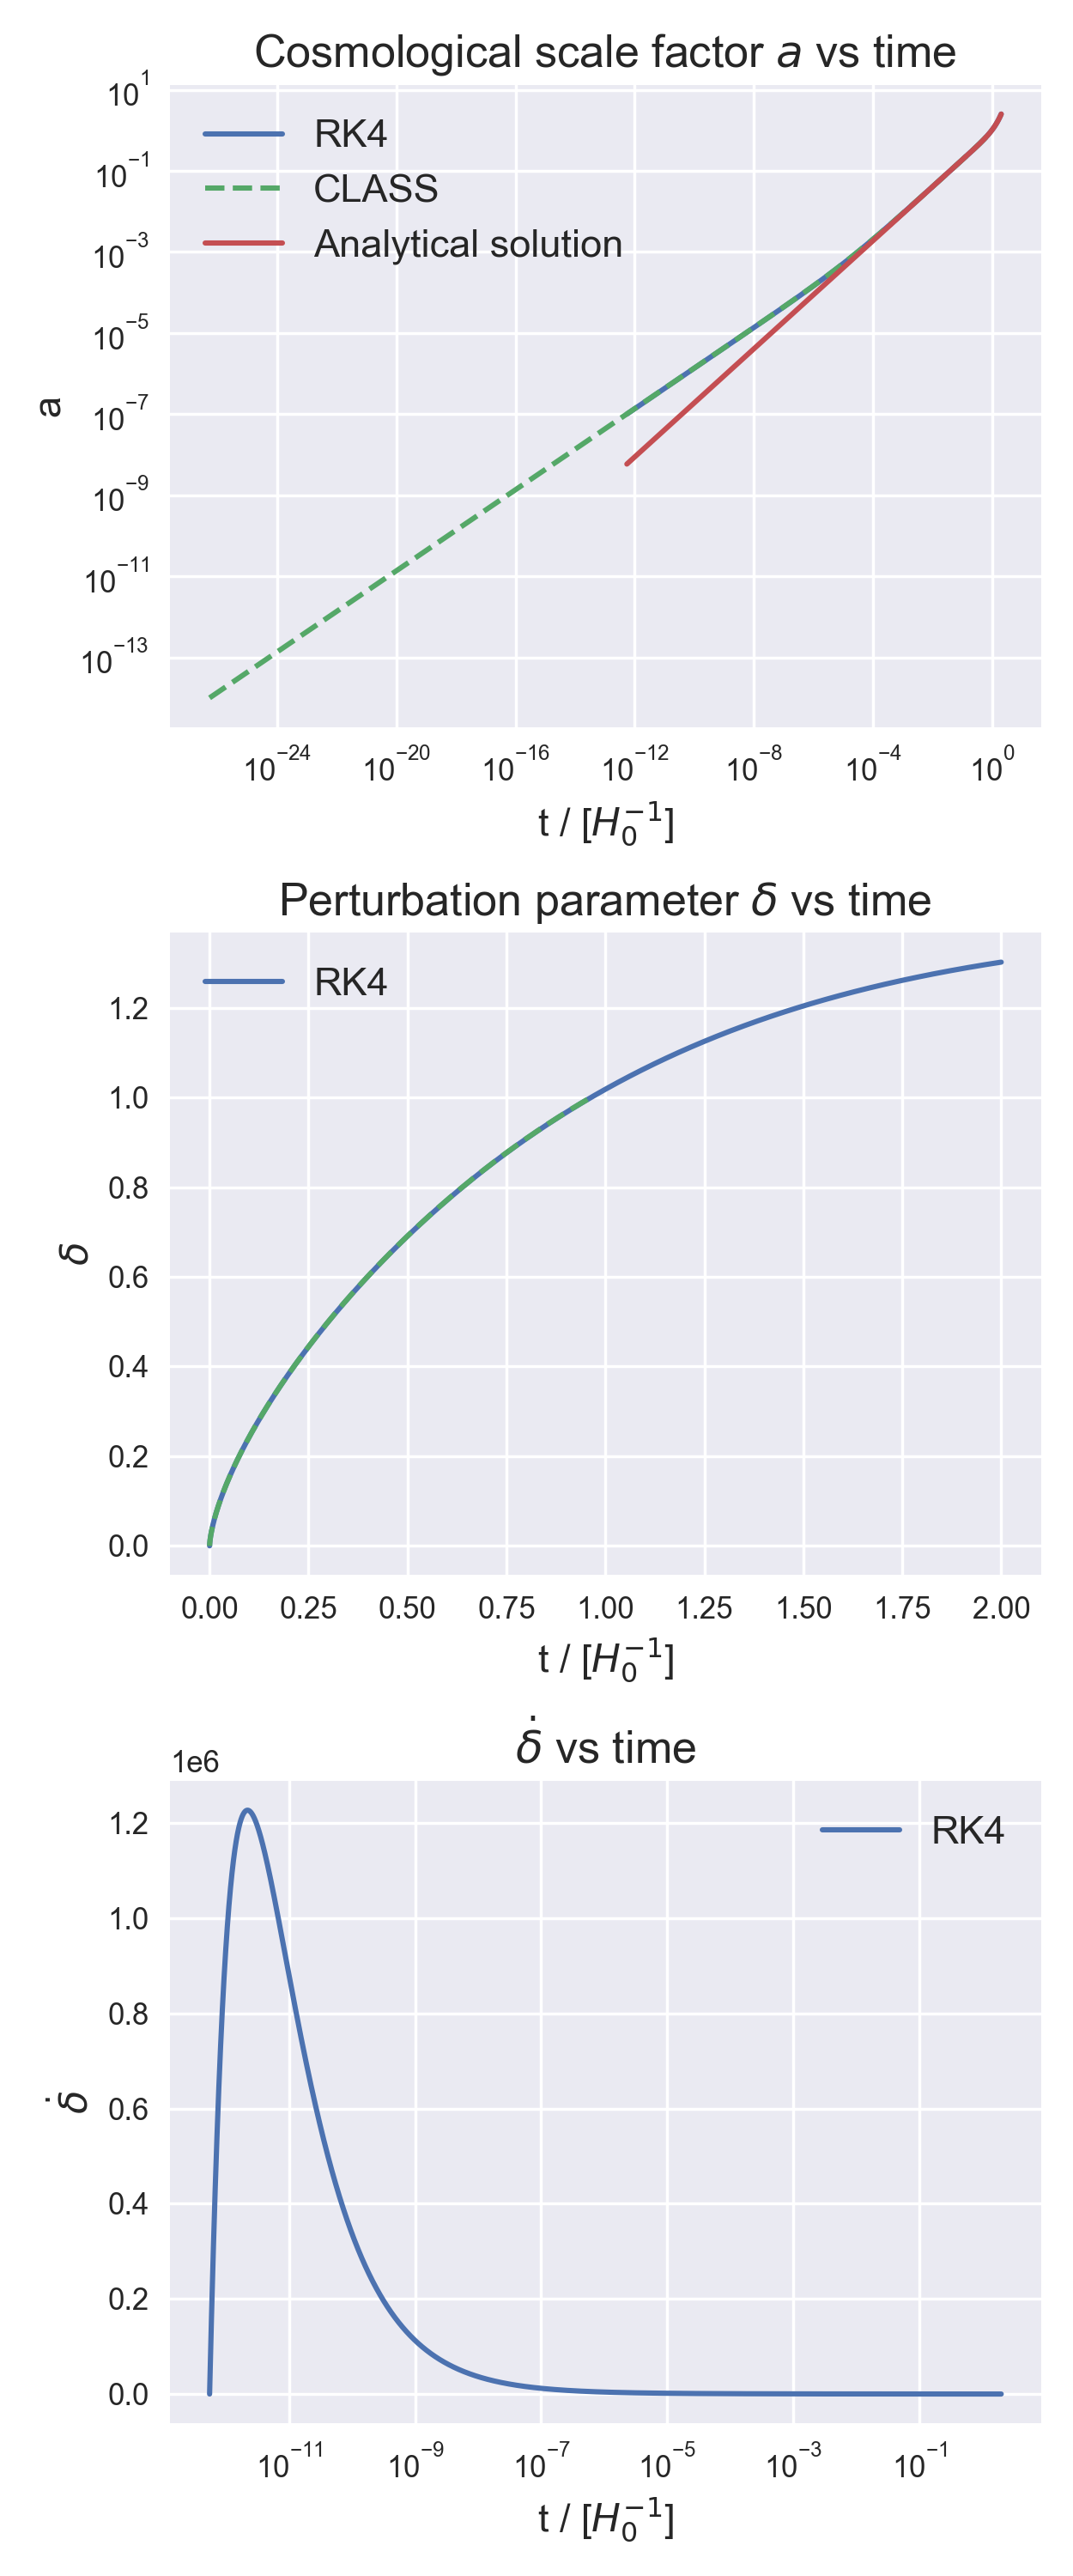

Text(0.5, 1.0, '$\\dot{\\delta}$ vs time')

In [20]:
fig,ax = plt.subplots(3,1,tight_layout=True,figsize=(5,12))
ax[0].plot(ts,vals[:,2],label='RK4')
ax[0].plot(bg['proper time [Gyr]']*0.001022*70, 1/(1 + bg['z']), label='CLASS', ls='--')
ax[0].plot(ts,analyticalAs, label='Analytical solution')
ax[0].legend(fontsize=13)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r't / [$H_0^{-1}$]',fontsize=13)
ax[0].set_ylabel('a',fontsize=13)
ax[0].set_title(r'Cosmological scale factor $a$ vs time',fontsize=15)

dtoday = np.interp(1, vals[:,2], vals[:,0])

ax[1].plot(ts,vals[:,0]/dtoday,label='RK4')
ax[1].legend(fontsize=13)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].plot(bg['proper time [Gyr]']*0.001022*70, d, label='CLASS', ls='--')
ax[1].set_xlabel(r't / [$H_0^{-1}$]',fontsize=13)
ax[1].set_ylabel(r'$\delta$',fontsize=13)
ax[1].set_title(r'Perturbation parameter $\delta$ vs time',fontsize=15)

ax[2].plot(ts,vals[:,1],label='RK4')
ax[2].legend(fontsize=13)
ax[2].set_xscale('log')
ax[2].set_xlabel(r't / [$H_0^{-1}$]',fontsize=13)
ax[2].set_ylabel(r'$\dot{\delta}$',fontsize=13)
ax[2].set_title(r'$\dot{\delta}$ vs time',fontsize=15)